# Computational Simulation of Equivalence Class Formation Using the go/no-go Procedure with Compound Stimuli

### Abstract
Research about equivalence has commonly utilized human participants as experimental subjects. More recently, computational models have been capable of reproducing performances observed in experiments with humans. The computational model often utilized is called RELNET, and it simulates training and testing trials of conditional relations using the matching-to-sample procedure (MTS). The differentiation between sample stimulus and comparison stimuli, indispensable in MTS, implies operational difficulties for simulations. For this reason, new studies seek to utilize alternative procedures to MTS, which do not differentiate the functions of the antecedent stimuli. This work evaluated the possibility of developing a new computational model to simulate equivalence class formation using the go/no-go procedure with compound stimuli. In Experiment 1, artificial neural networks were utilized to simulate training of the AB and BC relations as well as the testing of the AC relation. The results showed that four out of six runs demonstrated equivalence class formation. Experiment 2 evaluated whether the additional class training performed in Experiment 1, which was analogous to the simulation of pre-experimental experience of human participants, would be essential for simulating the establishment of equivalence classes. It was found that it was not possible to simulate equivalence class formation without the additional class training. Altogether, the experiments show that it is possible to simulate equivalence class formation using the go/no-go procedure with compound stimuli and that it is necessary to conduct additional class training. The model developed is, therefore, an alternative to RELNET for the study of equivalence relations using computational simulations.

[article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4960284/pdf/40732_2016_Article_184.pdf)

In [26]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import csv

from multiprocessing import Pool

%matplotlib inline
plt.style.use('seaborn')

# TensorFlow replica

[XOR example (simplest)](https://medium.com/@jaschaephraim/elementary-neural-networks-with-tensorflow-c2593ad3d60b)
[MNIST example](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network_raw.ipynb)

In [27]:
train_1_X=[
    [0.,0.,0.,1.,0.,1.,0.,0.,0.],# 0 0 0 1 0 1 0 0 0 
    [0.,1.,0.,0.,0.,1.,0.,0.,0.],# 0 1 0 0 0 1 0 0 0
    [0.,1.,0.,1.,0.,0.,0.,0.,0.],# 0 1 0 1 0 0 0 0 0
    [1.,0.,0.,0.,0.,0.,0.,1.,0.],# 1 0 0 0 0 0 0 1 0  
    [1.,0.,1.,0.,0.,0.,0.,0.,0.],# 1 0 1 0 0 0 0 0 0 
    [0.,0.,0.,0.,1.,0.,0.,1.,0.],# 0 0 0 0 1 0 0 1 0 
    [0.,0.,0.,0.,0.,0.,1.,1.,0.],# 0 0 0 0 0 0 1 1 0 
    [0.,0.,1.,0.,0.,0.,0.,0.,1.],# 0 0 1 0 0 0 0 0 1
    [0.,0.,0.,0.,0.,0.,0.,1.,1.],# 0 0 0 0 0 0 0 1 1 
    [0.,0.,1.,0.,0.,0.,1.,0.,0.],# 0 0 1 0 0 0 1 0 0
    [0.,0.,1.,0.,1.,0.,0.,0.,0.] # 0 0 1 0 1 0 0 0 0 
]

train_1_y=[1,1,1,1,0,1,0,1,0,1,0] 

test_1_X=[
    [1.,0.,0.,0.,1.,0.,0.,0.,0.],
    [1.,0.,0.,0.,0.,0.,1.,0.,0.],
    [0.,0.,0.,0.,0.,0.,1.,0.,1.],
    [0.,0.,0.,0.,1.,0.,0.,0.,1.]
]

test_1_y=[1,0,1,0]

train_2_X=[
    [1.,0.,0.,0.,1.,0.],# 1 0 0 0 1 0
    [1.,1.,0.,0.,0.,0.],# 1 1 0 0 0 0
    [0.,0.,1.,0.,1.,0.],# 0 0 1 0 1 0
    [0.,0.,0.,1.,1.,0.],# 0 0 0 1 1 0
    [0.,1.,0.,0.,0.,1.],# 0 1 0 0 0 1
    [0.,0.,0.,0.,1.,1.],# 0 0 0 0 1 1
    [0.,1.,0.,1.,0.,0.],# 0 1 0 1 0 0
    [0.,1.,1.,0.,0.,0.] # 0 1 1 0 0 0 
]

train_2_y=[1,0,1,0,1,0,1,0]

test_2_X=[
    [1.,0.,1.,0.,0.,0.],# 1 0 1 0 0 0
    [1.,0.,0.,1.,0.,0.],# 1 0 0 1 0 0 
    [0.,0.,0.,1.,0.,1.],# 0 0 0 1 0 1
    [0.,0.,1.,0.,0.,1.],# 0 0 1 0 0 1
]

test_2_y=[1,0,1,0]


In [28]:
def predict_net(train_in,test_in,train_out_list,hidden_units=4, report=False, max_epochs=20000):

    #variables
    input_units=len(train_in[0])
    train_out=[[float(i)]for i in train_out_list]#train_1_y
    output_units=1

    # tf session preparation
    x  = tf.placeholder("float", shape=[None, input_units])# Not in original code
    y_ = tf.placeholder("float", shape=[None, output_units])# Not in original code

    w1 = tf.Variable(tf.random_normal([input_units, hidden_units]))
    b1 = tf.Variable(tf.zeros([hidden_units]))

    w2 = tf.Variable(tf.random_normal([hidden_units, output_units]))
    b2 = tf.Variable(tf.zeros([output_units]))

    out1 = tf.sigmoid(tf.add(tf.matmul(x, w1), b1))# train_in
    out2 = tf.sigmoid(tf.add(tf.matmul(out1, w2), b2))

#     error = tf.subtract(y_, out2)
#     mse = tf.reduce_mean(tf.square(error))
    mse = tf.losses.mean_squared_error(y_, out2)

    train = tf.train.GradientDescentOptimizer(0.3).minimize(mse)

    # Trainning session

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    err, target = 1, 0.0025
    epoch = 0
    mserr=[]

    if report: 
        strt=time.time()

    while err > target and epoch < max_epochs:
        epoch += 1
        err, _ = sess.run([mse, train],feed_dict={x:train_in, y_:train_out})
        mserr.append(err)

    if report: 
        converg_time=time.time()-strt
        print("epoch:", epoch, "mse:", err, "time:", converg_time)

    train_prediction=out2.eval(feed_dict={x: train_in},session=sess)
    test_prediction=out2.eval(feed_dict={x: test_in},session=sess)
    sess.close()

    return mserr,train_prediction,test_prediction

## Individual Test

In [29]:
err_trn, pred_trn,pred_tst=predict_net(train_2_X,test_2_X,train_2_y,
                                           report=True, max_epochs=20000)

epoch: 4355 mse: 0.00249914 time: 7.724090337753296


In [30]:
pred_trn

array([[ 0.96755934],
       [ 0.05096339],
       [ 0.95769978],
       [ 0.04446635],
       [ 0.94447851],
       [ 0.04823207],
       [ 0.94728076],
       [ 0.06618413]], dtype=float32)

In [31]:
pred_tst

array([[ 0.45072731],
       [ 0.6599372 ],
       [ 0.35834631],
       [ 0.80635977]], dtype=float32)

## Iteraciones

In [ ]:
iteraciones=1000
#n_reports=20

n_iter_train_1=[]
predict_train_1=[]
predict_test_1=[]


n_iter_train_2=[]
predict_train_2=[]
predict_test_2=[]

converg_times=[]
filename="TF_replicas"


# with open(''.join(["Results_1/",filename,".csv"]), 'wb') as f:# 'wb' are the second parameter sugested values
#     writer = csv.writer(f)
#     writer.writerow(["exp_1_n_iter".encode(),
#                      "exp_1_pred_train_1".encode(),
#                      "exp_1_pred_train_2".encode(),
#                      "exp_1_pred_train_3".encode(),
#                      "exp_1_pred_train_4".encode(),
#                      "exp_1_pred_train_5".encode(),
#                      "exp_1_pred_train_6".encode(),
#                      "exp_1_pred_train_7".encode(),
#                      "exp_1_pred_train_8".encode(),
#                      "exp_1_pred_train_9".encode(),
#                      "exp_1_pred_train_10".encode(),
#                      "exp_1_pred_train_11".encode(),
#                      "exp_1_pred_test_1".encode(),
#                      "exp_1_pred_test_2".encode(),
#                      "exp_1_pred_test_3".encode(),
#                      "exp_1_pred_test_4".encode(),
#                      "exp_2_final_loss".encode(),
#                      "exp_2_n_iter".encode(),
#                      "exp_2_pred_train_1".encode(),
#                      "exp_2_pred_train_2".encode(),
#                      "exp_2_pred_train_3".encode(),
#                      "exp_2_pred_train_4".encode(),
#                      "exp_2_pred_train_5".encode(),
#                      "exp_2_pred_train_6".encode(),
#                      "exp_2_pred_train_7".encode(),
#                      "exp_2_pred_train_8".encode(),
#                      "exp_2_pred_test_1".encode(),
#                      "exp_2_pred_test_2".encode(),
#                      "exp_2_pred_test_3".encode(),
#                      "exp_2_pred_test_4".encode()
#                     ])

In [ ]:
for corrida in range(iteraciones):
    strt_time=time.time()
    
#     if __name__ == '__main__':
#         pool = Pool()
#         err_list_1, pred_train_1,pred_test_1=predict_net(train_1_X,test_1_X,train_1_y)
#         err_list_2, pred_train_2,pred_test_2=predict_net(train_2_X,test_2_X,train_2_y)    
#         pool.close() 
#         pool.join()
    
    err_list_1, pred_train_1,pred_test_1=predict_net(train_1_X,test_1_X,train_1_y)
    err_list_2, pred_train_2,pred_test_2=predict_net(train_2_X,test_2_X,train_2_y)    

    iter_vals=[item for sublist in [[len(err_list_1)],
                                    [float(p) for p in pred_train_1],
                                    [float(p) for p in pred_test_1],
                                    [err_list_2[-1]],
                                    [len(err_list_2)],
                                    [float(p) for p in pred_train_2],
                                    [float(p) for p in pred_test_2],
                                   ] for item in sublist]


#     converg_times.append(end_time-strt_time)

    with open(''.join(["Results_1/",filename,".csv"]), 'a') as f:# 'wb' are the second parameter sugested values
        writer = csv.writer(f)
        writer.writerow(iter_vals)
    
    end_time=time.time()
    print("iter: ", str(corrida), "| time: ", str(end_time-strt_time))


iter:  0 | time:  18.537548542022705
iter:  1 | time:  18.03176712989807
iter:  2 | time:  20.799051523208618
iter:  3 | time:  23.15109133720398
iter:  4 | time:  27.270599603652954
iter:  5 | time:  19.940468072891235
iter:  6 | time:  20.980915546417236
iter:  7 | time:  17.32917833328247
iter:  8 | time:  22.719426155090332
iter:  9 | time:  21.977590560913086
iter:  10 | time:  17.873807430267334
iter:  11 | time:  22.94185161590576
iter:  12 | time:  21.77287220954895
iter:  13 | time:  19.545446395874023
iter:  14 | time:  19.013571977615356
iter:  15 | time:  21.300862312316895
iter:  16 | time:  22.01407217979431
iter:  17 | time:  19.992845058441162
iter:  18 | time:  24.84894561767578
iter:  19 | time:  26.59269380569458
iter:  20 | time:  23.16156506538391
iter:  21 | time:  23.113062858581543
iter:  22 | time:  27.489007234573364
iter:  23 | time:  17.499541759490967
iter:  24 | time:  18.405539989471436
iter:  25 | time:  20.901774406433105
iter:  26 | time:  20.894913434

# Results

In [4]:
dat=pd.read_csv("Results_1/TF_replicas.csv", 
                header=None, 
                names=(["exp_1_n_epocs",
                        "XY_1",
                        "YZ_1",
                        "XZ_1",
                        "A1B1_1",
                        "A1B2_1",
                        "B1C1_1",
                        "B1C2_1",
                        "A2B2_1",
                        "A2B1_1",
                        "B2C2_1",
                        "B2C1_1",
                        "A1C1_1",
                        "A1C2_1",
                        "A2C2_1",
                        "A2C1_1",
                        "exp_2_final_loss",
                        "exp_2_n_epocs",
                        "A1B1_2",
                        "A1B2_2",
                        "B1C1_2",
                        "B1C2_2",
                        "A2B2_2",
                        "A2B1_2",
                        "B2C2_2",
                        "B2C1_2",
                        "A1C1_2",
                        "A1C2_2",
                        "A2C2_2",
                        "A2C1_2",
                       ]))# , sep=";" # para bases en español #_hid_4_1
#dat=pd.read_csv("Results_1/test_hid_4_1.csv")# , sep=";" # para bases en español #_hid_4_1
print(len(dat))
print(list(dat.columns))

1004
['exp_1_n_epocs', 'XY_1', 'YZ_1', 'XZ_1', 'A1B1_1', 'A1B2_1', 'B1C1_1', 'B1C2_1', 'A2B2_1', 'A2B1_1', 'B2C2_1', 'B2C1_1', 'A1C1_1', 'A1C2_1', 'A2C2_1', 'A2C1_1', 'exp_2_final_loss', 'exp_2_n_epocs', 'A1B1_2', 'A1B2_2', 'B1C1_2', 'B1C2_2', 'A2B2_2', 'A2B1_2', 'B2C2_2', 'B2C1_2', 'A1C1_2', 'A1C2_2', 'A2C2_2', 'A2C1_2']


count     1004.000000
mean      5386.564741
std       1140.021401
min       3311.000000
25%       4751.000000
50%       5165.000000
75%       5651.000000
max      20000.000000
Name: exp_1_n_epocs, dtype: float64

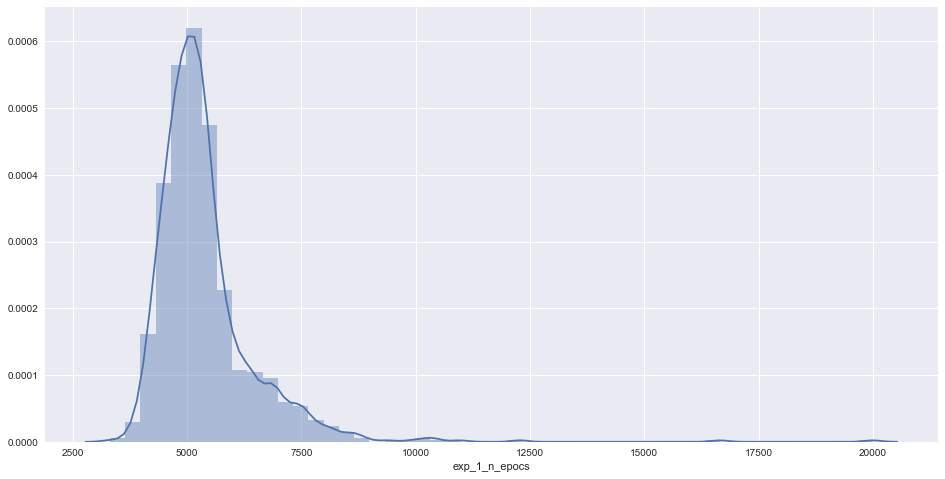

In [5]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(dat["exp_1_n_epocs"])
dat["exp_1_n_epocs"].describe()

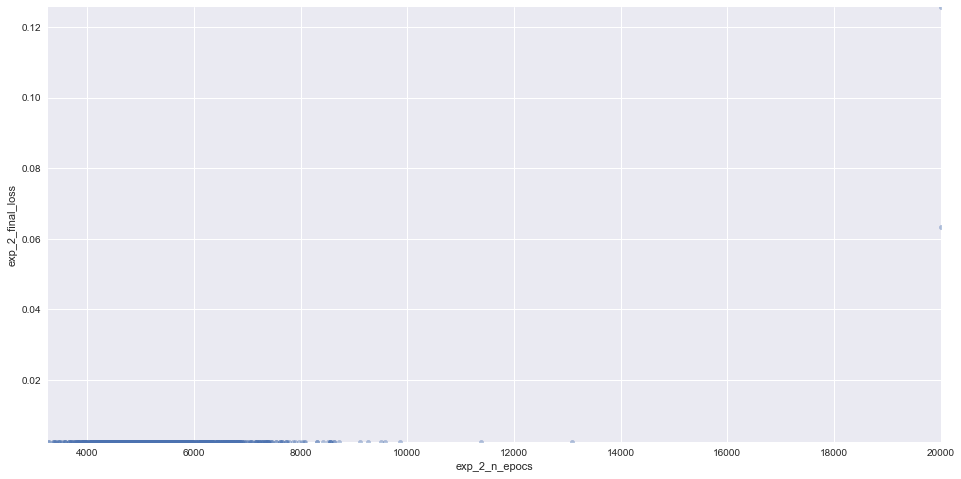

In [6]:
dat.plot.scatter(
    x='exp_2_n_epocs',
    y='exp_2_final_loss',
    ylim=(dat["exp_2_final_loss"].min(),dat["exp_2_final_loss"].max()),
    xlim=(dat["exp_2_n_epocs"].min(),dat["exp_2_n_epocs"].max()),
    figsize=(16,8),
    alpha=0.4
)

In [7]:
dat["exp_2_final_loss"].describe()

count    1004.000000
mean        0.002683
std         0.004334
min         0.002499
25%         0.002499
50%         0.002500
75%         0.002500
max         0.125685
Name: exp_2_final_loss, dtype: float64

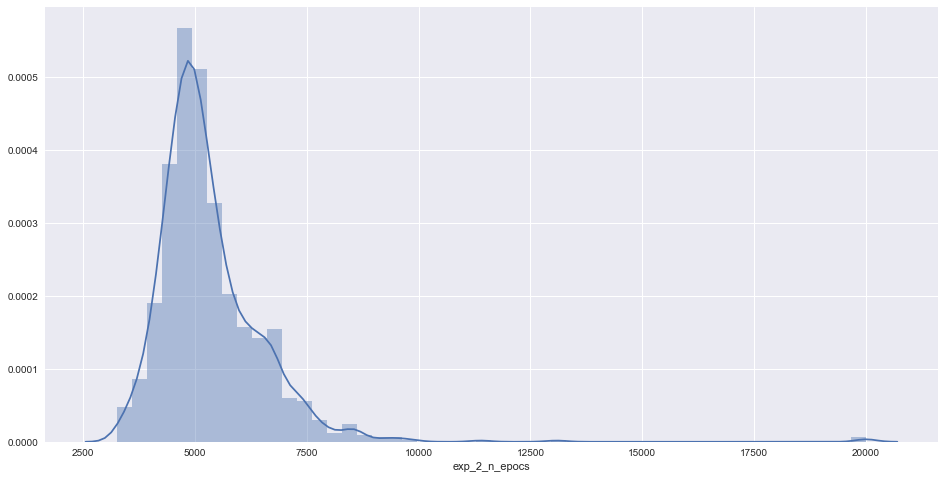

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(dat["exp_2_n_epocs"])

In [10]:
dat.iloc[:,1:12].describe()

,XY_1,YZ_1,XZ_1,A1B1_1,A1B2_1,B1C1_1,B1C2_1,A2B2_1,A2B1_1,B2C2_1,B2C1_1
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.994284,0.994323,0.994334,0.942925,0.056757,0.942546,0.056954,0.942454,0.057892,0.942214,0.056943
std,0.005656,0.005702,0.005604,0.014558,0.012463,0.014535,0.012196,0.011400,0.023159,0.011263,0.012410
min,0.954656,0.963098,0.960281,0.665261,0.020818,0.665476,0.016614,0.899097,0.021987,0.901392,0.019297
25%,0.991704,0.992016,0.991910,0.935834,0.049066,0.936051,0.050413,0.936096,0.049571,0.935487,0.049343
50%,0.996088,0.996025,0.996129,0.941949,0.056799,0.941802,0.057813,0.942041,0.057313,0.941373,0.057082
75%,0.998494,0.998490,0.998456,0.948581,0.064607,0.948186,0.064581,0.948711,0.064971,0.947675,0.064477
max,0.999951,0.999949,0.999956,0.981005,0.097960,0.983363,0.093558,0.981105,0.670206,0.981170,0.103744


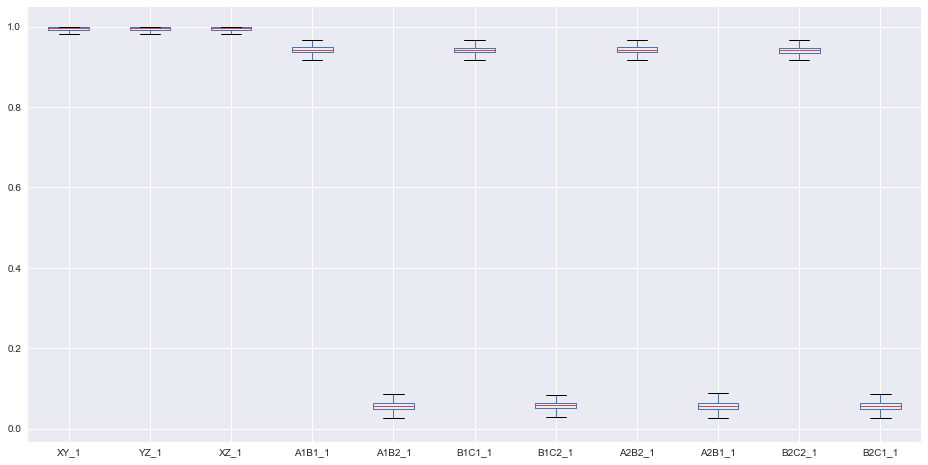

In [11]:
dat.iloc[:,1:12].plot(kind="box", figsize=(16,8))#, alpha=0.6)

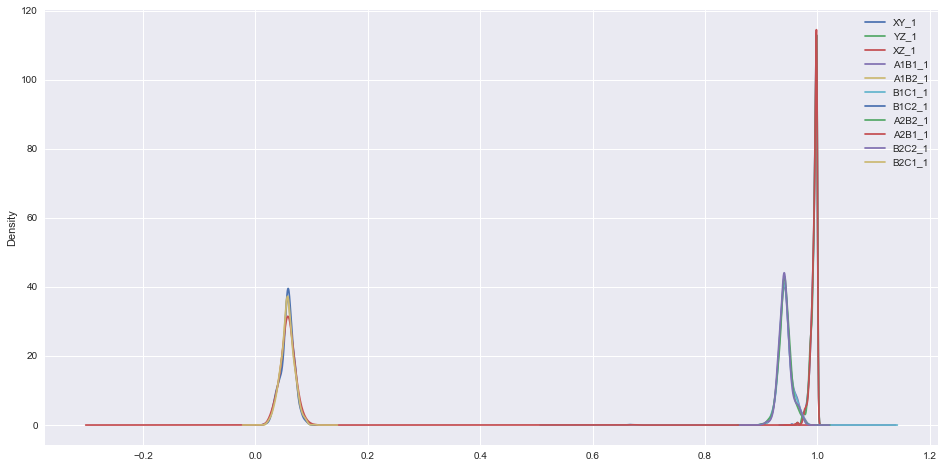

In [12]:
dat.iloc[:,1:12].plot(kind="density", figsize=(16,8))#, alpha=0.6)

In [13]:
dat.iloc[:,12:16].describe()

,A1C1_1,A1C2_1,A2C2_1,A2C1_1
count,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.726698,0.361439,0.726499,0.363054
std,0.297733,0.301665,0.301648,0.300727
min,0.015175,0.017632,0.009058,0.009571
25%,0.549379,0.111468,0.564741,0.116560
50%,0.888807,0.230640,0.893181,0.233833
75%,0.946806,0.596881,0.945781,0.603454
max,0.998250,0.990314,0.998706,0.990754


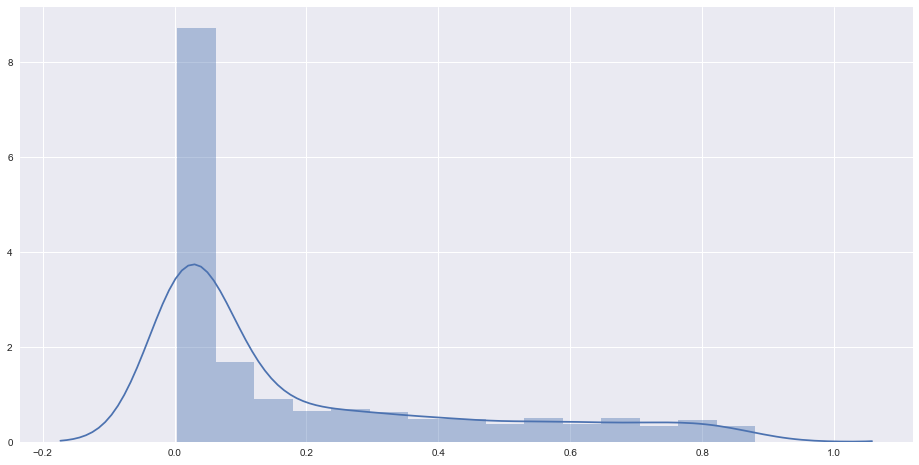

In [16]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(np.mean((dat.iloc[:,12:16]-test_1_y)**2, axis=1) )

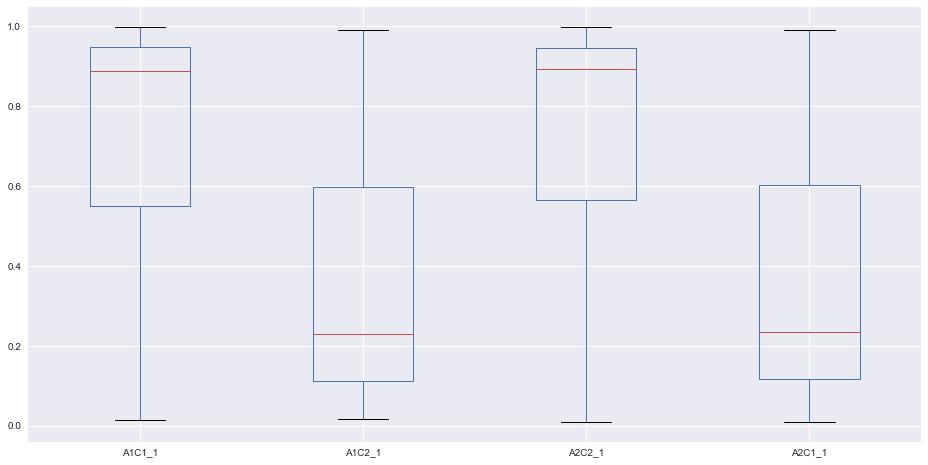

In [17]:
dat.iloc[:,12:16].plot(kind="box", figsize=(16,8))#, alpha=0.6)

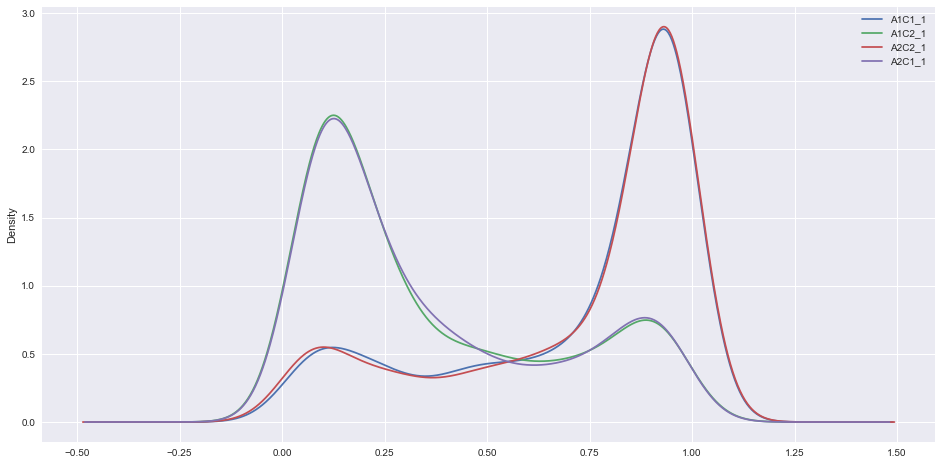

In [18]:
dat.iloc[:,12:16].plot.density(figsize=(16,8))

In [19]:
dat.iloc[:,18:26].describe()

,A1B1_2,A1B2_2,B1C1_2,B1C2_2,A2B2_2,A2B1_2,B2C2_2,B2C1_2
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.951455,0.049520,0.951304,0.049338,0.950796,0.048038,0.950696,0.049200
std,0.011580,0.023120,0.011565,0.011171,0.018179,0.011268,0.023131,0.018562
min,0.914467,0.002455,0.910443,0.013088,0.498868,0.011808,0.498214,0.013984
25%,0.944258,0.042668,0.944377,0.043859,0.944487,0.042439,0.944788,0.042603
50%,0.950312,0.049383,0.950017,0.049835,0.950393,0.049394,0.950495,0.049920
75%,0.957678,0.055379,0.957866,0.056051,0.956680,0.055326,0.956838,0.055433
max,0.982619,0.501282,0.983520,0.093870,0.987839,0.088324,0.982810,0.500736


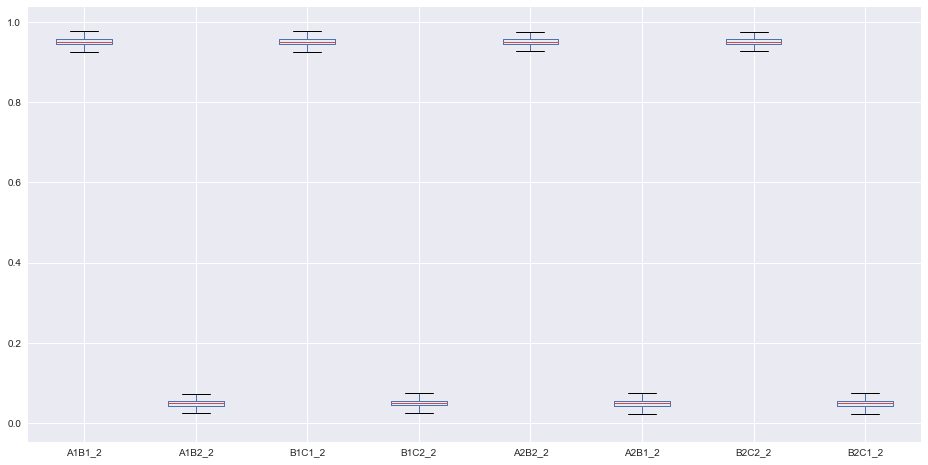

In [20]:
dat.iloc[:,18:26].plot(kind="box", figsize=(16,8))#, alpha=0.6)

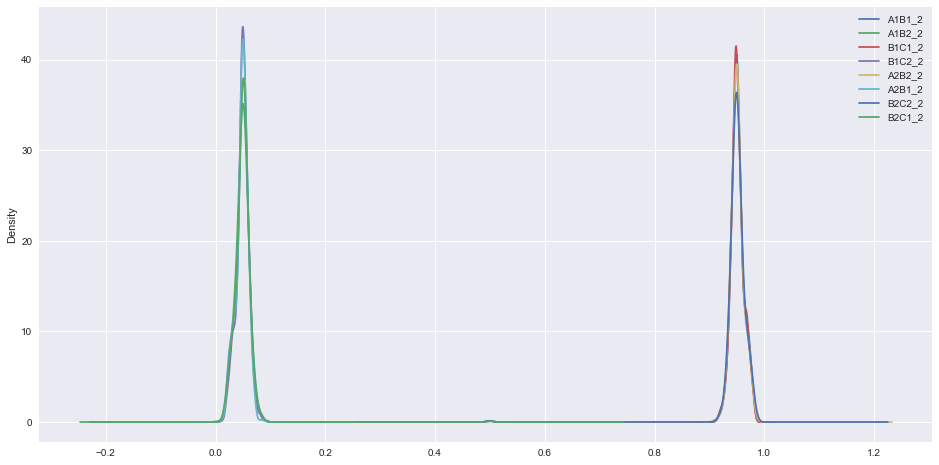

In [21]:
dat.iloc[:,18:26].plot(kind="density", figsize=(16,8))#, alpha=0.6)

In [22]:
dat.iloc[:,26:30].describe()

,A1C1_2,A1C2_2,A2C2_2,A2C1_2
count,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.485722,0.507239,0.492189,0.490303
std,0.368720,0.348728,0.367051,0.351241
min,0.006500,0.018049,0.013481,0.012295
25%,0.086043,0.133308,0.092151,0.124125
50%,0.454109,0.539605,0.481441,0.449485
75%,0.891743,0.871346,0.892366,0.870075
max,0.990869,0.985554,0.993155,0.983411


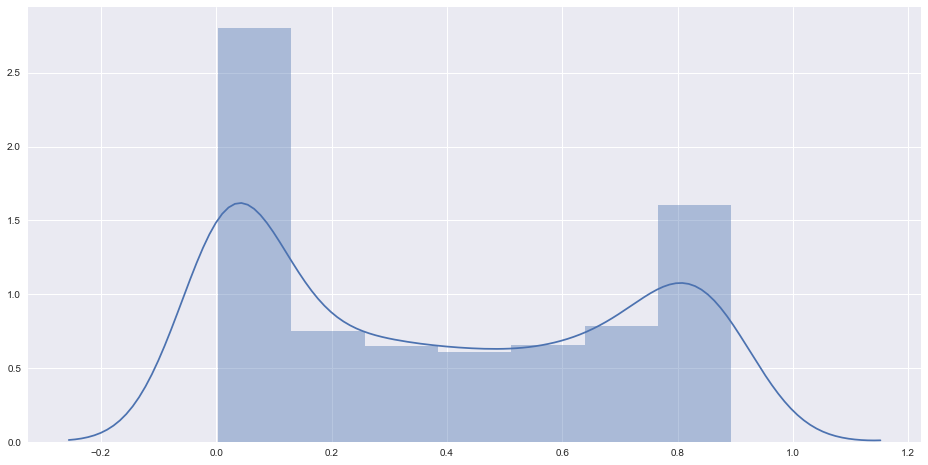

In [23]:
fig, ax = plt.subplots(figsize=(16,8))
sns.distplot(np.mean((dat.iloc[:,26:30]-test_1_y)**2, axis=1) )

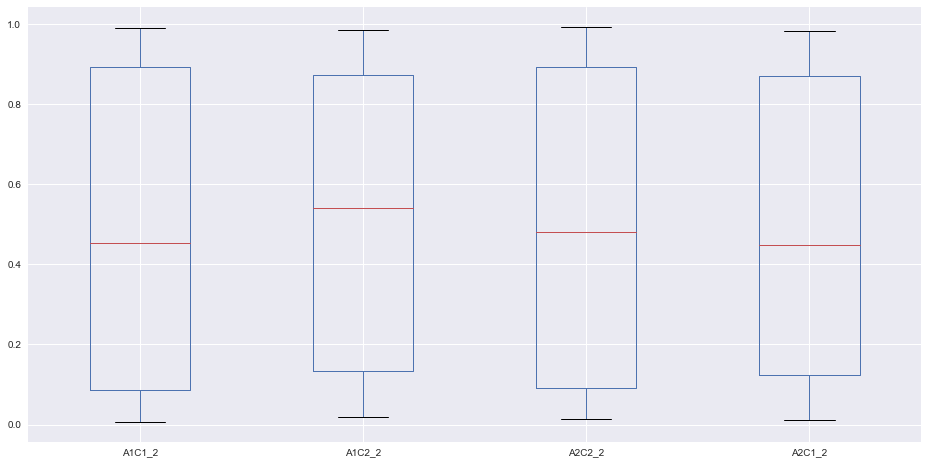

In [24]:
dat.iloc[:,26:30].plot(kind="box", figsize=(16,8))#, alpha=0.6)

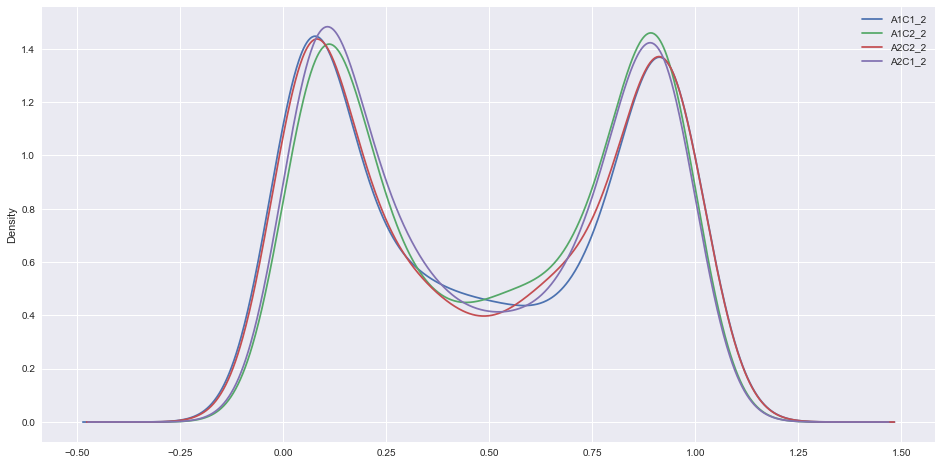

In [25]:
dat.iloc[:,26:30].plot(kind="density", figsize=(16,8))#, alpha=0.6)